# 11 Reprojecting

In this section we will:
- practice merging data frames
- apply `if-else` statements for flow control
- reproject geospatial data 
- create a choropleth map

## About the data

The first dataset we will use is a [list of Arctic communities and their location](https://search.dataone.org/view/doi%3A10.18739%2FA28S4JQ80) @brook_approximate_2023 created by the [Alaska Native Tribal Health Consortium](https://www.anthc.org). This data comess in GeoJSON file with the following attributes:

- **name**: name of Arctic community, 
- **population**: population of Arctic community, as of 2022
- **country**: country that the Arctic community falls within (see dataset metadata for the codes)
- **geoname-id**: numeric codes that uniquely identify all administrative/legal and statistical geographic areas for which the Census Bureau tabulates data

The second dataset is [Natural Earth's medium scale  cultural boundaries data for countries (1:50m)](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/). 
We can obtain this dataset by downloading the shapefile. 
[Natural Earth](https://www.naturalearthdata.com) is a public domain dataset with ready-to-use data for creating maps. 

## Import data

We will first import the countries shapefile and adapt it for wrangling purposes:

**EXERCISE** 

The following code has 4 bugs, find them and correct them in order to udpate the data.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# -------------------------------------------------------
# Import data

# Path to course data folder
data_folder_fp = os.path.join('/',
                              'courses',
                              'EDS220', # Missing comma 
                              'data')

# Import countries shapefile
fp = os.path.join(data_folder_fp, 
                  'ne_50m_admin_0_countries', 
                  'ne_50m_admin_0_countries.shp') # Missing .shp 
countries = gpd.read_file(fp)
countries.columns = countries.columns.str.lower()  # Simplify column names

# Import Arctic communities GeoJSON directly from URL
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL) # Change from read_csv to read_file

# Import country names CSV
fp = os.path.join(data_folder_fp, 
                  'country_names', 
                  'country_names.csv')
country_names = pd.read_csv(fp) # Change gpd to pd 

In [2]:
countries = countries[['admin', 'type', 'geometry']]
countries.head(3)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."


In [3]:
communities.head(3)

,name,population,country,geoname-id,geometry
0,Udomlya,32373,RU,452949,POINT (34.99250 57.87944)
1,Valmiera,26963,LV,453754,POINT (25.42751 57.54108)
2,Ventspils,42644,LV,454310,POINT (21.57288 57.38988)


In [4]:
country_names

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia
3,LT,Lithuania
4,SE,Sweden
5,BY,Belarus
6,FI,Finland
7,NO,Norway
8,DK,Denmark
9,FO,Faroe Islands


In [5]:
# Check CRS of communities 
communities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Check CRS of countries 
countries.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The `countires` geodataframe is actually also EDS 84, but internally they are represented slightly differently. 

To be on the safe side, we will reproject to make sure both datasets have the same CRS. 

**Reprojecting** means changing coordinate referencce systems of your geospatial data. 

Changing CRSs in geopandas is as the following: 

```python 
updated_geodf = geodf.to_crs(new_crs)
```

where: 

- `updated_geodf` = the output of th method with the updated CRS 
- `geodf` = the geodataframe that we want to reproject 
-  `new_crs` = CRS we are reprojecting to 

In [7]:
# Reprojecting countries to ensure CRS consistency
countries = countries.to_crs(communities.crs)

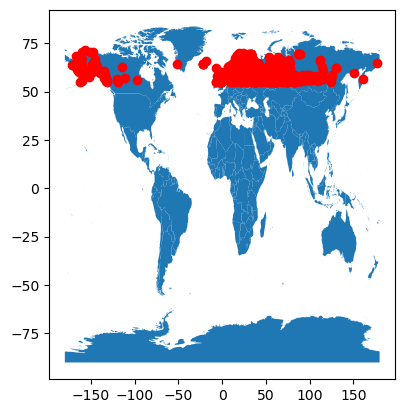

In [8]:
# Plot geospatial data 

assert countries.crs == communities.crs

fid, ax = plt.subplots()
countries.plot(ax=ax)
communities.plot(ax=ax, color = 'red')
plt.show()

## Artic communites by country 

In [9]:
# Create a dataframe with the number fo communities per country 
n_comms = (communities.groupby('country')
                        .size()
                        .reset_index(name = 'n_communities'))

Our goal is to merge the `n_comms` and the `countries` data frame to create a chorpleth map. 

To merge two data frames they need to have one column in common. Currentlly, our datasets have no column in common:

In [10]:
countries.columns

Index(['admin', 'type', 'geometry'], dtype='object')

In [11]:
n_comms.columns

Index(['country', 'n_communities'], dtype='object')

In [12]:
# Find the intersection between countries cols and n_comms cols 
set(countries.columns).intersection(n_comms.columns)

set()

The empty set means there is no intersection between the column names. 

## Merge the data 
We can use the country name to merge the columns 

In [13]:
n_comms.head(2)

,country,n_communities
0,AX,1
1,BY,8


In [14]:
countries.head(2)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."


In [15]:
country_names.head(3)

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia


To merge: 

```python 
output_df = pd.merge(left_df,
                    right_df,
                    how=type_of_join,
                    on=column_to_join)
```
- `how` = type of join: 'inner', 'left', 'right'


In [16]:
# Merge country_names with communites 
n_comms = pd.merge(n_comms,
                  country_names,
                  how='left',
                  on='country')
n_comms

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia
5,FI,98,Finland
6,FO,1,Faroe Islands
7,GB,96,United Kingdom
8,GL,1,Greenland
9,IS,5,Iceland


In [17]:
# Merge countries and communites 
arctic_countries = pd.merge(countries,
                           n_comms,
                           how='inner',
                           on='admin')
arctic_countries

,admin,type,geometry,country,n_communities
0,United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
1,United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
2,Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
3,Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
4,Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48
5,Lithuania,Sovereign country,"MULTIPOLYGON (((20.95781 55.27891, 20.89980 55...",LT,26
6,Latvia,Sovereign country,"POLYGON ((26.59355 55.66753, 26.54287 55.67241...",LV,25
7,Iceland,Sovereign country,"POLYGON ((-15.54312 66.22852, -15.42847 66.224...",IS,5
8,Finland,Country,"MULTIPOLYGON (((24.15547 65.80527, 24.04902 65...",FI,98
9,Estonia,Sovereign country,"MULTIPOLYGON (((27.35195 57.52812, 27.32656 57...",EE,14


When doing the inner join, we dropped the Aland Islands from the n_comms dataset. 

In [18]:
# Check Aland Islands is no where in countries data frame 
'Aland Islands' in countries.values

False

In [24]:
# Set the index to admin column
arctic_countries = arctic_countries.set_index('admin')

In [25]:
arctic_countries.head(3)

,type,geometry,country,n_communities
admin,,,,
United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133


In [21]:
# .at uses the index to alter a value in a column 
arctic_countries.at['Finland', 'n_communities'] += 1

<Axes: >

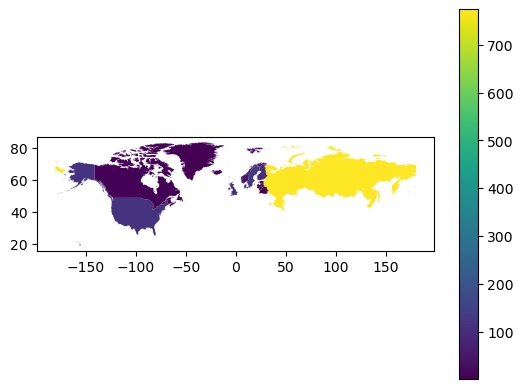

In [22]:
# Plot 
arctic_countries.plot(column='n_communities',
                     legend=True)

**Reprojecting** means changing the coordinate reference system of your geospatial data. In our case, we will reproject the Alaska geo-dataframe to the CRS EPSG:3413. This CRS is a projected CRS, better suited for working with data from the Arctic region:

In [26]:
# Reproject to CRS optimized for Arctic region
arctic_countries = arctic_countries.to_crs('epsg:3413')

<Axes: >

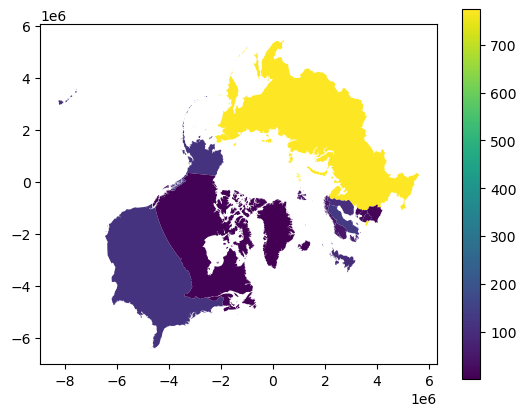

In [27]:
# Plot with new projection 
arctic_countries.plot(column='n_communities',
                     legend=True)